# Application of Fuzzy logic and Genetic Algorithms in Stock Trading

This notebook explores the application of genetic algorithms in optimizing the fuzzy rules as applied in technical analysis of stocks.

In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import math
import random
import itertools
from typing import Union, Literal
from functools import reduce
from re import X
import numpy as np
import pandas as pd
import ta
import matplotlib.pyplot as plt
import copy

                Close       Open       High        Low   Volume
Date                                                           
1986-01-02   172.6575   172.6575   172.6575   172.6575    600.0
1986-01-03   172.6575   172.6575   172.6575   172.6575   1900.0
1986-01-06   175.4879   175.4879   175.4879   175.4879   2800.0
1986-01-07   181.1488   175.4879   181.1488   175.4879   3200.0
1986-01-09   181.1488   181.1488   181.1488   181.1488   2600.0
...               ...        ...        ...        ...      ...
2023-09-12  1781.0000  1786.0000  1809.0000  1781.0000  12985.0
2023-09-13  1787.0000  1799.0000  1799.0000  1781.0000  16850.0
2023-09-14  1795.0000  1795.0000  1795.0000  1782.0000  12070.0
2023-09-15  1752.0000  1795.0000  1810.0000  1752.0000  29105.0
2023-09-18  1752.0000  1789.0000  1789.0000  1752.0000  27225.0

[8861 rows x 5 columns]


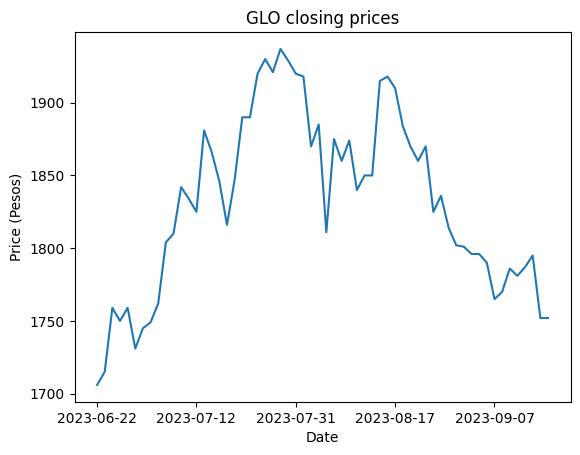

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../Data/PH-historical-stock-price-data-csv/GLO.csv', header = 0, index_col = 'Date')
print(series)

# plot historical stock price data
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(series['Close'].tail(60))
ax.set_xticks(ax.get_xticks()[::13])
plt.show()

In [3]:
# define the triangular membership function
def trimf(val:int, vector:list[int]) -> float:
    """
    Triangular Membership Function
        This function calculates the fuzzy value of a crisp input using a triangular membership function.  
    
    Arguments:
        val:int
            crisp value to be fuzzified
            
        vector:list[int]
            a vector with 3 values pertaining to the left base, peak, and right base of the triangular membership function.
            the vector shoul satisfy the following property:
            a < b < c
        
    Returns
        fuzzy_value: float
            fuzzified value from the crisp value
    """
    
    # check if the vector is of length 3
    assert len(vector) == 3, "the length of the vector must be equal to 3"
    
    # unpack and check the values of the vector if it statisfies the property a <= b <= c
    a, b, c = vector
    assert a < b, "a must be less than to b"
    assert b < c, "b must be less than to c"
    
    
    # compute for the fuzzy value from the crisp value
    if val <= a:
        return  0.0
    elif (val >= a) and (val <= b):
        return (val - a)/(b - a)
    elif (val >= b) and (val <= c):
        return (c - val)/(c - b) 
    elif val >= c:
        return 0.0

In [4]:
# define the linear membership function
def linearf(val:int, vector:list[int], positive_slope:bool = True) -> float:
    """
    This function computes for th1e degree of membership of a crisp value to its fuzzy counterpart through a linear membership function
    Arguments
        val:int
            The value to be fuzzified; it a should be less than be, i.e. a < b
        
        vector:list[int]
            A length 2 vector that defines the linear boundaries of the 
            linear membership function
    
        positive_slope:bool
            boolean paramater that checks if the slope to be used is positive or negative

    Returns
        fuzzy_value:float
            The fuzzified value from the crisp input
    """

    # check if the input vector is of length 2
    assert len(vector) == 2, "The vector must of of length 2"
    
    # unpack the vector and check if it statisfies the property a < b
    a, b = vector
    assert a < b, "a must be less than b"
    
    # compute for the fuzzy value from the crisp value
    # if the linear membership function has a positive slope
    if positive_slope:
       if val < a:
           return 0
       elif val > b:
           return 1
       else:
           return (val - a)/(b - a)
    
    # if the linear membership function has a negative slope
    else:
       if val < a:
           return 1
       elif val > b:
           return 0
       else:
           return  (b - val)/(b - a)

In [5]:
# build a class that will encapsulate a stock and perform fuzzy technical analysis on it
class fuzzy_TA:
    def __init__(self, df: pd.DataFrame):
        """
        Arguments:
            df: pd.DataFrame
                pandas dataframe containing the closing, opening, high, low, and volume of a stock
                
        Returns:
        """
        
        self.df = df
        self.u = pd.DataFrame(index = self.df.index)
        self.z = pd.DataFrame(index = self.df.index)
        self.u_sum = pd.DataFrame(index = self.df.index)
        self.z_sum = pd.DataFrame(index = self.df.index)
    # MOMENTUM INDICATORS
    
    def RSI(self, 
            window:int          = 14,
            fillna:bool         = False,
            p1:float            = 1,
            p2:float            = 1,
            p3:float            = 1,
            p4:float            = 1,
            lo_left_node: int   = 0,
            lo_right_node: int  = 50,
            md_left_node: int   = 0,
            md_middle_node: int = 50,
            md_right_node: int  = 100,
            hi_left_node: int   = 50,
            hi_right_node: int  = 100
            ):
        """
        Relative Stregth Index
    
        Arguments
            window: int
                window or number of elements to be included in the calculation

            fillna: bool
                if True, fill NaN values
            
            p1: float
                value to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant
                this value ranges from 0 to 1

            p2: float
                value to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant
                this value ranges from 0 to 1

            p3: float
                value to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant
                this value ranges from 0 to 1

            p3: float
                value to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant
                this value ranges from 0 to 1    
                
        Returns
        """
        
        # compute for the RSI of the stock
        self.df[f'RSI{window}'] = (ta.momentum.RSIIndicator(
            close = self.df['Close'],
            window = window,
            fillna = fillna)
            .rsi()
        )
        
        # compute for the membership values of the RSI values
        self.u[f'RSI{window}_lo'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [lo_left_node, lo_right_node], positive_slope = False))
        self.u[f'RSI{window}_md'] = self.df[f'RSI{window}'].apply(lambda x: trimf(x, [md_left_node, md_middle_node, md_right_node])) 
        self.u[f'RSI{window}_hi'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [hi_left_node, hi_right_node], positive_slope = True))
        
        # the following are the fuzzy rules for RSI
        # if RSI is low, then buy
        self.z[f'RSI{window}_lo'] = (p1 * ((self.u[f'RSI{window}_lo'] * 25)  + 75))
        
        # # if RSI is medium, then hold
        mask = (self.df[f'RSI{window}'] < 50)
        self.z.loc[mask, f'RSI{window}_md'] = (p2 * ((self.u[f'RSI{window}_md'] * -25) + 75))
        
        mask = (self.df[f'RSI{window}'] > 50)
        self.z.loc[mask, f'RSI{window}_md'] = (p3 * ((self.u[f'RSI{window}_md'] * 25) + 25))

        # if RSI is high then sell
        self.z[f'RSI{window}_hi'] = (p4 * ((self.u[f'RSI{window}_hi'] * -25) + 25))
        
    def StochRSI(self, window:int = 14, smooth1:int = 3, smooth2:int = 3, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Stochastic RSI
        
            This method computes for the stochastic RSI of a given series.


        Arguments:
            window: int
                window or number of elements to be included in the calculation of RSI

            smooth1: int
                first smoothing constant in computing the stochasting RSI

            smooth2: int
                second smoothing constant in computing the stochasting RSI

            fillna: bool
                if True, fill NaN values        
            
            p0: float
                constant to be passed in the consequent of the Tsukamoto model
            
            p1: float
                constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant

        Returns:
            None
        """
        
        # calculate the stochasting RSI
        self.df[f'StochRSI{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'StochRSI{window}_lo'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0, 0.2], positive_slope = False))
        self.u[f'StochRSI{window}_md'] = self.df[f'StochRSI{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'StochRSI{window}_hi'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0.8, 1], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'StochRSI{window}_lo'] = p0 + (p1 * ((self.u[f'StochRSI{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'StochRSI{window}'] < 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'StochRSI{window}'] > 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'StochRSI{window}_hi'] = p0 + (p1 * ((self.u[f'StochRSI{window}_hi'] * -25) + 25))

    def StochRSI_KxD(self, window:int = 14, smooth1:int = 1, smooth2:int = 3, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Stochastic RSI Cross
        
            This method computes for the stochastic RSI
            k is the slow indicator
            d is the fast indicator
        
        Arguments:
            window: int
                window used in the computation of the stochastic RSI
                
            smooth1: int
                first smoothing constant used in computing the stochasting RSI
                
            smooth2: int
                second smoothing constant used in computing the stochastic RSI
                
            fillna: bool
                if True, fill NaN values

            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant

        Returns:
            None
        """
        
        # compute for the fast stochastic
        self.df[f'StochRSI_d{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )
        
        # compute for the slow stochastic
        self.df[f'StochRSI_k{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_k()
        )
        
        # compute for the KxD difference
        KxD_diff =  self.df[f'StochRSI_k{window}'] - self.df[f'StochRSI_d{window}']
        
        # calculate the membership values for low, medium and high RSI
        self.u[f'StochRSI_KxD{window}_neg'] = KxD_diff.apply(lambda x: linearf(x, [-0.10, 0], positive_slope = False))
        self.u[f'StochRSI_KxD{window}_zero'] = KxD_diff.apply(lambda x: trimf(x, [-0.10, 0, 0.10])) 
        self.u[f'StochRSI_KxD{window}_pos'] = KxD_diff.apply(lambda x: linearf(x, [0, 0.10], positive_slope = True))
        
        # the following are the fuzzy rules for PPO
        # if PPO_hist is postive then buy
        self.z[f'StochRSI_KxD{window}_pos'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_pos'] * 25) + 75))
        
        # if PPO_hist is zero
        mask = (KxD_diff > 0)
        # if KxD_diff is above 0, then lean towards buying
        self.z.loc[mask, f'StochRSI_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_zero'] * -25) + 75))

        mask = (KxD_diff <= 0)
        # if KxD_diff is less than or equal to  0, then lean towards selling
        self.z.loc[mask, f'StochRSI_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_zero'] * 25) + 25))

        # if KxD_diff is negative then sell
        self.z[f'StochRSI_KxD{window}_neg'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_neg'] * -25) + 25))
        
    def WilliamsR(self, window:int = 14, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Compute for the williams R 
        
        Arguments:
            window: int
                the window used in the computation of the WilliamsR

            fillna: bool
                if True, fill NaN values

            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant

        Returns:
            None        
        """
        # compute for Williams % R
        self.df[f'WilliamsR{window}'] = (
            ta.momentum.WilliamsRIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                lbp = window,
                fillna = fillna)
            .williams_r()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'WilliamsR{window}_lo'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-100, -80], positive_slope = False))
        self.u[f'WilliamsR{window}_md'] = self.df[f'WilliamsR{window}'].apply(lambda x: trimf(x, [-100, -50, 0])) 
        self.u[f'WilliamsR{window}_hi'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-20, 0], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'WilliamsR{window}_lo'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'WilliamsR{window}'] < -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'WilliamsR{window}'] >= -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'WilliamsR{window}_hi'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_hi'] * -25) + 25))

    def Ultimate(self, window1:int = 7, window2:int = 14, window3:int = 28, weight1:float = 4.0, weight2:float = 2.0, weight3:float = 1.0, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Ultiimate oscilator
        
        Arguments:
            window1:int
                short period

            window2:int
                medium period

            window3:int
                long period

            weight1:float
                weight of short BP average for UO

            weight2:float
                weight of medium BP average for UO

            weight3:float
                weight of long BP average for UO

            fillna: bool
                if True, fill NaN values    

            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant
                
        Returns:
            None
        """
        
        # compute for the Ultimate oscillator
        self.df[f'Ultimate{window1}'] = ta.momentum.ultimate_oscillator(
            high = self.df['High'], 
            low = self.df['Low'], 
            close = self.df['Close'], 
            window1 = window1, 
            window2 = window2, 
            window3 = window3, 
            weight1 = weight1, 
            weight2 = weight2, 
            weight3 = weight3, 
            fillna = fillna)
    
        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'Ultimate{window1}_lo'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'Ultimate{window1}_md'] = self.df[f'Ultimate{window1}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'Ultimate{window1}_hi'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for ultimate oscillator
        # if ultimate is low, then buy
        self.z[f'Ultimate{window1}_lo'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_lo'] * 25)  + 75))
        
        # if ultimate is medium and ultimate is below 50 then do this; borderlining to buying
        mask = (self.df[f'Ultimate{window1}'] < 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * -25) + 75))
        
        # if ultimate is medium and ultimate is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'Ultimate{window1}'] >= 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * 25) + 25))

        # if ultimate is high then sell
        self.z[f'Ultimate{window1}_hi'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_hi'] * -25) + 25))

    def TSI(self, window_slow:int = 25, window_fast:int = 13, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        True Strength Index
        
        Arguments:
            window_slow:int
                window for calculating the slow period
            
            window_fast:int
                window for calculating the slow period
            
            fillna: bool
                if True, fill NaN values

            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant

        Returns:
            None
        """

        # compute for the TSI of the stock
        self.df[f'TSI{window_slow}x{window_fast}'] = (ta.momentum.tsi(
            close = self.df['Close'],
            window_slow = 25,
            window_fast = 13,
            fillna = False)
        )

        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'TSI{window_slow}x{window_fast}_lo'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [-0.5, -0.25], positive_slope = False))
        self.u[f'TSI{window_slow}x{window_fast}_md'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: trimf(x, [-0.5, 0, 0.5])) 
        self.u[f'TSI{window_slow}x{window_fast}_hi'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [0.25, 0.5], positive_slope = True))


        # the following are the fuzzy rules for ultimate oscillator
        # if TSI is low, then buy
        self.z[f'TSI{window_slow}x{window_fast}_lo'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_lo'] * 25)  + 75))
        
        # if TSI is medium, then hold
        self.z[f'TSI{window_slow}x{window_fast}_md'] = p0 + (p1 * (50))

        # if TSI is high then sell
        self.z[f'TSI{window_slow}x{window_fast}_hi'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_hi'] * -25) + 25))


    # VOLUME INDICATORS

    def CMF(self, window:int = 20, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Chaikin Money Flow
        
        Arguments:
            window:int
                window or number of elements to be included in the calculation of CMF

            fillna: bool
                if True, fill NaN values
            
            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant

        
        Returns:
            None
        """
        
        
        self.df[f'CMF{window}'] = (
            ta.volume.chaikin_money_flow(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            )

        # CMF_val = self.df[f'CMF{window}'].iloc[-1]
        
        # calculate the membership values for low, medium and high CMF
        self.u[f'CMF{window}_lo'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [-1, 0], positive_slope = False))
        self.u[f'CMF{window}_md'] = self.df[f'CMF{window}'].apply(lambda x: trimf(x, [-1, 0, 1])) 
        self.u[f'CMF{window}_hi'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [0, 1], positive_slope = True))        
        
        # the following are the fuzzy rules for CMF
        # if CMF_val is negative then buy
        self.z[f'CMF{window}_lo'] = p0 + (p1 * ((self.u[f'CMF{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'CMF{window}'] < 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'CMF{window}'] >= 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'CMF{window}_hi'] = p0 + (p1 * ((self.u[f'CMF{window}_hi'] * -25) + 25))
        
    def MFI(self, window:int = 14, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Money Flow Index
        
        Arguments:
            window:int
                window or number of elements to be included in the calculation of MFI
            
            fillna: bool
                if True, fill NaN values
            
            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant

        Returns:
            None
        """
        # calculate the money flow index for the window
        self.df[f'MFI{window}'] = (
            ta.volume.MFIIndicator(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            .money_flow_index()
        )
        
        # calculate the membership values for low, medium and high MFI
        self.u[f'MFI{window}_lo'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'MFI{window}_md'] = self.df[f'MFI{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'MFI{window}_hi'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))


        # the following are the fuzzy rules for MFI
        # if CMF_val is negative then buy
        self.z[f'MFI{window}_lo'] = p0 + (p1 * ((self.u[f'MFI{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'MFI{window}'] < 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'MFI{window}'] >= 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'MFI{window}_hi'] = p0 + (p1 * ((self.u[f'MFI{window}_hi'] * -25) + 25))
            
    def RSI_OBV(self, window:int = 14, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Relative Stregth Index as applied on the On Balance Volume
        
        Arguments:
            window:
                window or number of elements to be included in the calculation of RSI_OBV

            fillna: bool
                if True, fill NaN values
                
            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant
        
        Returns:
            None
        
        """

        # compute for OBV
        self.df['OBV'] = (
            ta.volume.OnBalanceVolumeIndicator(
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                fillna = False)
            .on_balance_volume()
        )

        # normalize OBV
        volume_sum = self.df['OBV'].sum()
        self.df['OBV'] = (self.df['OBV']/volume_sum)*100

        # compute for the RSI of the stock
        self.df[f'RSI_OBV{window}'] = (
            ta.momentum.RSIIndicator(
                close = self.df['OBV'], 
                window = window, 
                fillna = fillna)
            .rsi()
        )
        
        # calculate the membership values for low, medium and high RSI_OBV
        self.u[f'RSI_OBV{window}_lo'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'RSI_OBV{window}_md'] = self.df[f'RSI_OBV{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'RSI_OBV{window}_hi'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for RSI_OBV
        # if RSI_OBV is low then buy
        self.z[f'RSI_OBV{window}_lo'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_lo'] * 25)  + 75))
        
        # if RSI_OBV is medium and RSI_OBV is below 50 then do this; borderlining to buying
        mask = (self.df[f'RSI_OBV{window}'] < 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * -25) + 75))
        
        # if RSI_OBV is medium and RSI_OBV is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'RSI_OBV{window}'] >= 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * 25) + 25))

        # if RSI_OBV is high then sell
        self.z[f'RSI_OBV{window}_hi'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_hi'] * -25) + 25))
    
    def StochOBV_KxD(self, window:int = 14, smooth1:int = 1, smooth2:int =3, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Stochastic OBV
        
            This method computes for the stochastic OBV 
            k is the slow indicator
            d is the fast indicator
        
        Arguments:
            window: int
                the window used in computing the stochastic OBV
                
            smooth1: int
                first smoothing factor used in computing stochastic OBV
                
            smooth2: int
                second smoothing factor used in computing stochastic OBV
                
            fillna: bool
                if True, fill NaN values

            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant

        Returns:
            None
        """
        
        # compute for OBV
        self.df['OBV'] = (
            ta.volume.OnBalanceVolumeIndicator(
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                fillna = False)
            .on_balance_volume()
        )

        # normalize OBV
        volume_sum = self.df['OBV'].sum()
        self.df['OBV'] = (self.df['OBV']/volume_sum)*100
        
        # compute for the stochastic of OBV
        self.df[f'StochOBV_d{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['OBV'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )
        self.df[f'StochOBV_k{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['OBV'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_k()
        )
        
        # compute for the KxD difference
        KxD_diff =  self.df[f'StochOBV_k{window}'] - self.df[f'StochOBV_d{window}']

        # calculate the membership values for low, medium and high RSI
        self.u[f'StochOBV_KxD{window}_neg'] = KxD_diff.apply(lambda x: linearf(x, [-0.4, 0], positive_slope = False))
        self.u[f'StochOBV_KxD{window}_zero'] = KxD_diff.apply(lambda x: trimf(x, [-0.4, 0, 0.4])) 
        self.u[f'StochOBV_KxD{window}_pos'] = KxD_diff.apply(lambda x: linearf(x, [0, 0.4], positive_slope = True))
        
        # the following are the fuzzy rules for PPO
        # if PPO_hist is postive then buy
        self.z[f'StochOBV_KxD{window}_pos'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_pos'] * 25) + 75))
        
        # if PPO_hist is zero
        mask = (KxD_diff > 0)
        # if KxD_diff is above  0, then lean towards buying
        self.z.loc[mask, f'StochOBV_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_zero'] * -25) + 75))

        mask = (KxD_diff <= 0)
        # if KxD_diff is less than or equal to  0, then lean towards selling
        self.z.loc[mask, f'StochOBV_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_zero'] * 25) + 25))

        # if KxD_diff is negative then sell
        self.z[f'StochOBV_KxD{window}_neg'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_neg'] * -25) + 25))
        
    # VOLATILITY INDICATORS
    def BB_pband(self, window:int = 20, window_dev:int = 2, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Bolinger percentage band
        
        Arguments:
            window: int
                window or number of elements to be included in the calculation of BB_pband

            window_dev:int
                n factor standard deviation

            fillna: bool
                if True, fill NaN values
                
            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model; this will act as a weighing constant
        
        Returns:
            None
        """
        
        self.df[f'BB_pband{window}'] = (ta.volatility.bollinger_pband(
            close = self.df['Close'], 
            window = window, 
            window_dev = window_dev, 
            fillna = fillna)
        )

        
        # calculate the membership values for low, medium and high RSI
        self.u[f'BB_pband{window}_lo'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [-0.2, 0], positive_slope = False))
        self.u[f'BB_pband{window}_md'] = self.df[f'BB_pband{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'BB_pband{window}_hi'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [1, 1.2], positive_slope = True))
        

        # the following are the fuzzy rules for BB_pband
        # if BB_pband is low then buy
        self.z[f'BB_pband{window}_lo'] = p0 + (p1 * ((self.u[f'BB_pband{window}_lo'] * 25) + 75))
        
        # if BB_pband is low
        mask = self.df[f'BB_pband{window}'] < 0
        # if BB_pband is less than 0, then lean towards buying
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * -25) + 75))

        mask = self.df[f'BB_pband{window}'] >= 0
        # if BB_pband is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * 25) + 25))

        # if BB_pband is high then sell
        self.z[f'BB_pband{window}_hi'] = p0 + (p1 * ((self.u[f'BB_pband{window}_hi'] * -25) + 25))
        
    # TREND INDICATORS
    
    def MACD(self, window_fast:int = 12, window_slow:int = 26, window_sign:int = 9, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        
        Arguments:
            window_fast: int
                some text
            
            window_slow: int
                some text

            window_sign: int
                some text
                
            fillna: bool
                some text
            
            p0: float
                some text
                
            p1: float
                some text
            
        Returns:
            None
        """
    
    
        # compute for MACD Line
        self.df[f'MACD{window_fast}_{window_slow}_line'] = (
            ta.trend.MACD(
                close = self.df['Close'], 
                window_fast = window_fast,
                window_slow = window_slow,
                window_sign = window_sign, 
                fillna = False)
            .macd()
        )
        
        # compute for MACD Difference
        self.df[f'MACD{window_fast}_{window_slow}_diff'] = (
            ta.trend.MACD(
                close = self.df['Close'], 
                window_fast = window_fast,
                window_slow = window_slow,
                window_sign = window_sign, 
                fillna = False)
            .macd_diff()
        )
        
        # compute for MACD signal
        self.df[f'MACD{window_fast}_{window_slow}_signal'] = (
            ta.trend.MACD(
                close = self.df['Close'], 
                window_fast = window_fast,
                window_slow = window_slow,
                window_sign = window_sign, 
                fillna = False)
            .macd_signal()
        )
        # set the index in u and z
        self.u = pd.DataFrame(index = self.df.index )
        self.z = pd.DataFrame(index = self.df.index )
 
        # get mask
        mask = (self.df[f'MACD{window_fast}_{window_slow}_signal'] < self.df[f'MACD{window_fast}_{window_slow}_line'])
        
        # this rule sets the buying condition of the MACD rule
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = 0
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = 1
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = p1 * 0
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = p1 * 100
        
        # get mask
        mask = (self.df[f'MACD{window_fast}_{window_slow}_signal'] > self.df[f'MACD{window_fast}_{window_slow}_line'])
        
        # this rule sets the selling condition of the MACD rule
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = 1
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = 0
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = p1 * 0
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = p1 * 100


    def CCI(self, window:int = 20, constant:float = 0.0015, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Compute for the commodity channel index
        
        Arguments:
            window: int
                some text

            constant:float
                some text

            fillna: bool
                if True, fill NaN values
                
            p0: float
                a constant to be passed in the consequent of the Tsukamoto model
            
            p1: float
                a constant to be passed in the consequent of the Tsukamoto model
        
        Returns:
            None
        """
        # compute for the commodity channel index
        self.df[f'CCI{window}'] = (
            ta.trend.CCIIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                window = window,
                constant = constant,
                fillna = fillna)
            .cci()
        )

    
        # calculate the membership values for low, medium and high CCI
        self.u[f'CCI{window}_lo'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [-200, -100], positive_slope = False))
        self.u[f'CCI{window}_md'] = self.df[f'CCI{window}'].apply(lambda x: trimf(x, [-200, 0, 200])) 
        self.u[f'CCI{window}_hi'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [100, 200], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'CCI{window}_lo'] = p0 + (p1 * ((self.u[f'CCI{window}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'CCI{window}'] < 0
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * -25) + 75))

        mask = self.df[f'CCI{window}'] >= 0
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'CCI{window}_hi'] = p0 + (p1 * ((self.u[f'CCI{window}_hi'] * -25) + 25))
    
    def STC(self, window_slow:int = 50, window_fast:int = 30, cycle:int = 30, smooth1:int = 3, smooth2:int = 3, fillna = False, p0:float = 0, p1:float = 1) -> None:
        """
        Schaff Trend Cycle
        
        Arguments:
            window_slow:int
                some text

            window_fast:int
                some text

            cycle:int
                some text
            
            smooth1:int
                some text

            smooth2:int
                some text
            
            fillna: bool
                if True, fill NaN values

            p0: int
                a constant to be passed in the consequent of the Tsukamoto model

            p1: int
                a constant to be passed in the consequent of the Tsukamoto model
                
        Returns:
            None
        """
        
        self.df[f'STC{window_slow}'] = (
            ta.trend.STCIndicator(
                close = self.df['Close'],
                window_slow = window_slow,
                window_fast = window_fast,
                cycle = cycle,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stc()
        )
        
        # calculate the membership values for low, medium and high CCI
        self.u[f'STC{window_slow}_lo'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'STC{window_slow}_md'] = self.df[f'STC{window_slow}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'STC{window_slow}_hi'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'STC{window_slow}_lo'] = p0 + (p1 * ((self.u[f'STC{window_slow}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'STC{window_slow}'] < 50
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * -25) + 75))

        mask = self.df[f'STC{window_slow}'] >= 50
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'STC{window_slow}_hi'] = p0 + (p1 * ((self.u[f'STC{window_slow}_hi'] * -25) + 25))
        
    def PSAR(self, step:float = 0.02, max_step:float = 0.2, fillna:bool = False, p0:float = 0, p1:float = 1) -> None:
        """
        Parabolic SAR
        
        Arguments:        
            step:float
                some text
                
            max_step:float
                some text
                
            fillna: bool
                if True, fill NaN values
            
            p0:float
                a constant to be passed in the consequent of the Tsukamoto model

            p1:float
                a constant to be passed in the consequent of the Tsukamoto model

        Returns:
            None
        """
        
        # parabolic SAR
        self.df[f'PSAR{step}{max_step}'] = (ta.trend.PSARIndicator(
            high = self.df['High'],
            low = self.df['Low'],
            close = self.df['Close'],
            step = step,
            max_step = max_step,
            fillna = fillna)
            .psar()
        )
         
        # crude implementation of the PSAR rule
        # this rule defines the sell rule
        mask = (self.df[f'PSAR{step}{max_step}'] > self.df[f'Close'])
        self.u.loc[mask, f'PSAR{step}{max_step}_lo'] = 1
        self.u.loc[mask, f'PSAR{step}{max_step}_hi'] = 0
        self.z.loc[mask, f'PSAR{step}{max_step}_lo'] = p1 * 0
        self.z.loc[mask, f'PSAR{step}{max_step}_hi'] = p1 * 100
        
        # crude implementation of the PSAR rule
        # this rule defines the buy rule
        mask = (self.df[f'PSAR{step}{max_step}'] < self.df[f'Close'])
        self.u.loc[mask, f'PSAR{step}{max_step}_lo'] = 0
        self.u.loc[mask, f'PSAR{step}{max_step}_hi'] = 1
        self.z.loc[mask, f'PSAR{step}{max_step}_lo'] = p1 * 0
        self.z.loc[mask, f'PSAR{step}{max_step}_hi'] = p1 * 100

    # OTHER INDICATORS
    
    def Fisher_trans(self, window: int = 14, smooth2: int = 3, adjust: bool = True, p0 = 0, p1 = 1) -> None:
        """
        Fisher Transform
        
        Arguments:
            window: int
                some text
            
            smooth2: int
                some text
            
            adjust: bool
                some text
            
            fillna: bool
                if True, fill NaN values
            
            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model

        Returns
            None
        """
        
        np.seterr(divide='ignore')

        med = (self.df['High'] + self.df['Low']) / 2
        ndaylow = med.rolling(window=window).min()
        ndayhigh = med.rolling(window=window).max()
        raw = (2 * ((med - ndaylow) / (ndayhigh - ndaylow))) - 1
        smooth = raw.ewm(span=5, adjust=adjust).mean()
        _smooth = smooth.fillna(0)
        
        self.df[f'Fisher{window}'] = (
            (np.log((1 + _smooth) / (1 - _smooth)))
            .ewm(span=3, adjust=adjust)
            .mean()
        )
        
        # calculate the membership values for low, medium and high Fisher
        self.u[f'Fisher{window}_lo'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [-4, 0], positive_slope = False))
        self.u[f'Fisher{window}_md'] = self.df[f'Fisher{window}'].apply(lambda x: trimf(x, [-2, 0, 2])) 
        self.u[f'Fisher{window}_hi'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [0, 4], positive_slope = True))
        
        # the following are the fuzzy rules for Fisher
        # if Fisher is low, then buy
        self.z[f'Fisher{window}_lo'] = p0 + (p1 * ((self.u[f'Fisher{window}_lo'] * 25)  + 75))
        
        # if Fisher is medium and Fisher is less than 0, then buy
        mask = (self.df[f'Fisher{window}'] < 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * -25) + 75))
        
        # if Fisher is medium and Fisher is more than 0, then sell
        mask = (self.df[f'Fisher{window}'] >= 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * 25) + 25))

        # if Fisher is high then sell
        self.z[f'Fisher{window}_hi'] = p0 + (p1 * ((self.u[f'Fisher{window}_hi'] * -25) + 25))
    
    def Fisher_trans_KxD(self, window: int = 14, smooth2: int = 3, adjust: bool = True, weekly = False, monthly = False, p0 = 0, p1 = 1) -> None:
        """
        Fisher Transformation Cross
        
        Arguments:
            fillna: bool
                if True, fill NaN values
            
            p0: float
                a constant to be passed in the consequent of the Tsukamoto model

            p1: float
                a constant to be passed in the consequent of the Tsukamoto model
                
        Returns
            None
        """
        
        np.seterr(divide='ignore')

        med = (self.df['High'] + self.df['Low']) / 2
        ndaylow = med.rolling(window=window).min()
        ndayhigh = med.rolling(window=window).max()
        raw = (2 * ((med - ndaylow) / (ndayhigh - ndaylow))) - 1
        smooth = raw.ewm(span=5, adjust=adjust).mean()
        _smooth = smooth.fillna(0)

        # compute for the k and d smoothed fisher transforms
        fish_series_k = (np.log((1 + _smooth) / (1 - _smooth))).ewm(span=3, adjust=adjust).mean()
        fish_series_d = fish_series_k.rolling(smooth2).mean()
        
        # compute for the KxD difference
        KxD_diff = fish_series_k - fish_series_d
        
        # calculate the membership values for low, medium and high KxD_diff
        self.u[f'Fisher_KxD{window}_neg'] = KxD_diff.apply(lambda x: linearf(x, [-0.25, 0], positive_slope = False))
        self.u[f'Fisher_KxD{window}_zero'] = KxD_diff.apply(lambda x: trimf(x, [-0.13, 0, 0.13])) 
        self.u[f'Fisher_KxD{window}_pos'] = KxD_diff.apply(lambda x: linearf(x, [0, 0.25], positive_slope = True))
        
        # the following are the fuzzy rules for KxD_diff
        # if KxD_diff is postive then buy
        self.z[f'Fisher_KxD{window}_pos'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_pos'] * 25) + 75))
        
        # if KxD_diff is zero
        mask = (KxD_diff > 0)
        # if KxD_diff is above 0, then lean towards buying
        self.z.loc[mask, f'Fisher_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_zero'] * -25) + 75))

        mask = (KxD_diff <= 0)
        # if KxD_diff is less than or equal to  0, then lean towards selling
        self.z.loc[mask, f'Fisher_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_zero'] * 25) + 25))

        # if KxD_diff is negative then sell
        self.z[f'Fisher_KxD{window}_neg'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_neg'] * -25) + 25))
    
    
    def z_total(self):
        """
        Computes for the total z value for the consequent of the Tsukamoto model
        
        Arguments:        
            self
                the instance of the class
        
        Returns:
        """
        
        # add all u along axis 1 or the column
        self.u_sum['sum'] = self.u.sum(axis = 1)
        
        # initialize z_sum to be 0
        self.z['z_sum'] = 0
        
        # add all values of z across different technical indicator
        for col_name in self.u.columns:
            # produce mask that would remove NANs in the dataframe
            mask = ~(self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])).isna()
            
            # apply mask
            self.z.loc[mask, 'z_sum'] = self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])
        
        # compute for the normalized z_sum by u_sum
        self.df['z_sum'] = self.z['z_sum'] / self.u_sum['sum']
    

In [6]:
# create a function that splits the data into train and test sets
def split_train_test_sets(series: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    This function splits the time series data into train and test sets
    
    Arguments:
        series: pd.DataFrame
            a time series data of type
            
    Returns:
        train, test: tuple(pd.DataFrame, pd.DataFrame)
            the splitted train and test sets
    """
    # split into train and test sets
    train, test = series[1:-math.floor(len(series)*0.2)], series[-math.floor(len(series)*0.2):]
    return train, test

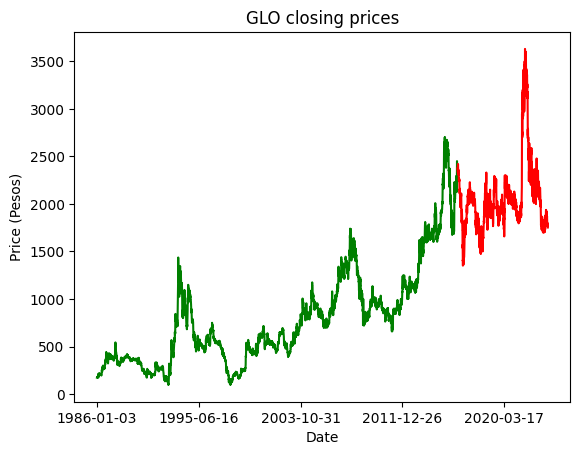

In [7]:
# split data into train and test sets
train, test = split_train_test_sets(series)

# plot the train and test sets
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(train['Close'], 'g')
ax.plot(test['Close'], 'r')
ax.set_xticks(ax.get_xticks()[::2000])
plt.show()

In [8]:
def split_train_set(series:pd.DataFrame, window:int = 500) -> list[pd.DataFrame]:
    """
    This function splits or slices the train set into batches with a corresponding window length

    Arguments:
        series:pd.DataFrame
            a pandas dataframe containing the training set of the 

    Returns:
        train_set:list[pd.DataFrame]
            a list containing multiple pandas dataframes
    """
    train_set = list()
    for i in range(len(series)-window):
        train_set.append(copy.deepcopy(series[i:i+window]))
    return train_set

In [9]:
# split the train set into multiple batches
train_set = split_train_set(train)
print(len(train_set))

6588


Gene list:

window: [1-300] 

p1: [0-1] 

p2: [0-1] 

p3: [0-1] 

p4: [0-1] 

lo_left_node: [1-100] 

lo_right_node: [1-100] 

md_left_node: [1-100] 

md_middle_node: [1-100] 

md_right_node: [1-100] 

hi_left_node: [1-100] 

hi_right_node: [1-100] 

long_condition: [1-100] 

short_condition: [1-100] 

In [10]:
class Gene():
    """
    This class provides details on a gene object
    """
    gene_id = itertools.count()

    def __init__(self, name:str, lower_bound:Union[int, float], upper_bound:Union[int, float], type:str, value: Union[int, float] = None):
        self.gene_id = next(Gene.gene_id)
        self.name = name
        self.value = value
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.type = type

    def initialize_gene(self):
        """
        This function initializes the gene
        
        Argument:
            self
                the instance of the class
        Returns:
        """

        if self.type == "int":
            self.value = random.randint(self.lower_bound, self.upper_bound)
        
        elif self.type == "float":
            self.value = random.uniform(self.lower_bound, self.upper_bound)
        
        elif self.type == "linear_membership":
            left_node = None
            right_node = None
            while left_node == right_node:
                left_node = random.randint(self.lower_bound, self.upper_bound)
                right_node = random.randint(left_node, self.upper_bound)
                self.value = [left_node, right_node]
        
        elif self.type == "triangular_membership":
            middle_node = random.randint(self.lower_bound, self.upper_bound)
            left_node = random.randint(self.lower_bound, middle_node)
            right_node = random.randint(middle_node, self.upper_bound)
            self.value = [left_node, middle_node, right_node]

        elif self.type == "entry_condition":
            short_condition = random.randint(self.lower_bound, self.upper_bound)
            long_condition = random.randint(short_condition, self.upper_bound)
            self.value = [short_condition, long_condition]

    def mutate(self):
        """
        This function mutates the gene

        Arguments:
            self
                the instance of the class
        
        Returns:
        """
        mutation_distribution_choices = ["uniform", "normal"]
        mutation_distribution = random.choice(mutation_distribution_choices)

        if mutation_distribution is "uniform":
            self.initialize_gene()

        elif mutation_distribution is "normal":

            if self.type == "int":
                self.value = random.normal(self.value, )
            
            elif self.type == "float":
                self.value = random.uniform(self.lower_bound, self.upper_bound)
            
            elif self.type == "linear_membership":
                left_node = random.randint(self.lower_bound, self.upper_bound-1)
                right_node = random.randint(left_node + 1, self.upper_bound)
                self.value = [left_node, right_node]
            
            elif self.type == "triangular_membership":
                middle_node = random.randint(self.lower_bound+1, self.upper_bound-1)
                left_node = random.randint(self.lower_bound, middle_node-1)
                right_node = random.randint(middle_node+1, self.upper_bound)
                self.value = [left_node, middle_node, right_node]

            elif self.type == "entry_condition":
                short_condition = random.randint(self.lower_bound, self.upper_bound-1)
                long_condition = random.randint(short_condition, self.upper_bound)
                self.value = [short_condition, long_condition]

    def __str__(self) -> str:
        """
        This function provides details of the instance of the class

        Arguments:
            self
                the instance of the class
        
        Returns:
            text:str
                a text string containing some information on the instance of the class
        """

        text = str()
        text = text + f"Gene name: {self.name}\nValue: {self.value}\n\n"
        return text

In [11]:
# create the gene list
gene_list = list()
gene_list = [
                Gene(
                    name = "RSI_window",
                    lower_bound = 1,
                    upper_bound = 300,
                    type = "int"),
            
                Gene(
                    name = "RSI_p1",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float"),
                
                Gene(
                    name = "RSI_p2",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float"),
                
                Gene(
                    name = "RSI_p3",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float"),

                Gene(
                    name = "RSI_p4",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float"),

                Gene(
                    name = "RSI_low_membership",
                    lower_bound = 0,
                    upper_bound = 100,
                    type = "linear_membership"),

                Gene(
                    name = "RSI_middle_membership",
                    lower_bound = 0,
                    upper_bound = 100,
                    type = "triangular_membership"),

                Gene(
                    name = "RSI_high_membership",
                    lower_bound = 0,
                    upper_bound = 100,
                    type = "linear_membership"),

                Gene(
                    name = "entry_condition",
                    lower_bound = 1,
                    upper_bound = 100,
                    type = "entry_condition"),

                Gene(
                    name = "stop_loss",
                    lower_bound = 0.01,
                    upper_bound = 0.99,
                    type = "float"),

                Gene(
                    name = "z_rolling_window",
                    lower_bound = 1,
                    upper_bound = 300,
                    type = "int")

            ]

In [12]:
# create the seed gene; this gene contains initial values believed to be good instance values
test_gene_list = list()
test_gene_list = [
                Gene(
                    name = "RSI_window",
                    lower_bound = 1,
                    upper_bound = 300,
                    type = "int",
                    value = 30),
            
                Gene(
                    name = "RSI_p1",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float",
                    value = 1),
                
                Gene(
                    name = "RSI_p2",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float",
                    value = 1),
                
                Gene(
                    name = "RSI_p3",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float",
                    value = 1),

                Gene(
                    name = "RSI_p4",
                    lower_bound = -1,
                    upper_bound = 1,
                    type = "float",
                    value = 1),

                Gene(
                    name = "RSI_low_membership",
                    lower_bound = 0,
                    upper_bound = 100,
                    type = "linear_membership",
                    value = [0, 25]),

                Gene(
                    name = "RSI_middle_membership",
                    lower_bound = 0,
                    upper_bound = 100,
                    type = "triangular_membership",
                    value = [25, 50, 75]),

                Gene(
                    name = "RSI_high_membership",
                    lower_bound = 0,
                    upper_bound = 100,
                    type = "linear_membership",
                    value = [75,100]),

                Gene(
                    name = "entry_condition",
                    lower_bound = 1,
                    upper_bound = 100,
                    type = "entry_condition",
                    value = [50,50]),

                Gene(
                    name = "stop_loss",
                    lower_bound = 0.01,
                    upper_bound = 0.99,
                    type = "float",
                    value = 0.95),

                Gene(
                    name = "z_rolling_window",
                    lower_bound = 1,
                    upper_bound = 300,
                    type = "int",
                    value = 30)

            ]

In [13]:
class Genome():
    """
    This class provides details on the genome object
    
    """
    genome_id = itertools.count()
    
    def __init__(self, gene_list:list[Gene]):
        """
        Initializes the Genome class
        
        Arguments:
            self
                the instance of the class

            gene_list:list[Gene]
                a list containing gene objects
        
        Returns:
        """
        self.genome_id = next(Genome.genome_id)
        self.genome = gene_list
        self.genome_dict = dict()
        self.update_genome_dict()
        
    def initialize_genome(self):
        """
        This function initializes the genome
        
        Arguments:
            self
                instance of the class
        Returns:
        """

        # loop through all the genes in the genome and initialize them individually
        for gene in self.genome:
            gene.initialize_gene()
            
        # update the dictionary of the genome
        self.update_genome_dict()

    def update_genome_dict(self):
        """
        This function updates the genome dictionary

        Arguments:
            self
                instance of the class

        Returns:
        """
        # loop through all the genes in the genome and assign them to the genome dictionary
        for gene in self.genome:
            self.genome_dict[gene.name] = gene

    def __str__(self) -> str:
        """
        This function provides information about the instance of the genome

        Arguments:
            self
                instance of the class

        Returns:
            text:str
                a text string containing some information about the genome instance
        """

        # loop through all the genes in the genome and provide the 
        # gene name and gene value of the gene
        text = str()
        for gene in self.genome:
            text = text + f"Gene name: {gene.name}\nValue: {gene.value}\n\n"
            
        return text

In [14]:
genome1 = Genome(test_gene_list)
print(genome1)

Gene name: RSI_window
Value: 30

Gene name: RSI_p1
Value: 1

Gene name: RSI_p2
Value: 1

Gene name: RSI_p3
Value: 1

Gene name: RSI_p4
Value: 1

Gene name: RSI_low_membership
Value: [0, 25]

Gene name: RSI_middle_membership
Value: [25, 50, 75]

Gene name: RSI_high_membership
Value: [75, 100]

Gene name: entry_condition
Value: [50, 50]

Gene name: stop_loss
Value: 0.95

Gene name: z_rolling_window
Value: 30




In [15]:
genome1 = Genome(gene_list)
genome1.initialize_genome()
print(genome1)

Gene name: RSI_window
Value: 124

Gene name: RSI_p1
Value: 0.8633691994898953

Gene name: RSI_p2
Value: 0.7159800478635281

Gene name: RSI_p3
Value: -0.7070855203926245

Gene name: RSI_p4
Value: 0.5691821935801351

Gene name: RSI_low_membership
Value: [35, 52]

Gene name: RSI_middle_membership
Value: [58, 75, 91]

Gene name: RSI_high_membership
Value: [97, 98]

Gene name: entry_condition
Value: [34, 98]

Gene name: stop_loss
Value: 0.24010894412442438

Gene name: z_rolling_window
Value: 131




In [16]:
def sortino_ratio(portfolio_returns:float ,std_downside_portfolio_returns:float, risk_free_rate_returns:float = 2.5) -> float:
    """
    This function computes for the sortino ratio of a given strategy

    Arguments:
        portoflio_returns:float
            the portfolio returns of a strategy
        
        std_downside_portfolio_returns:float
            the standard deviation of the downside of the portfolio retunrs of a strategy

        risk_free_rate_returns:flaot
            the percent return of a risk free strategy (e.g. bonds, bank interests, time deposits, etc.)
    
    Returns:
        sortino_ratio:float
            the sortino ratio of the strategy
    """

    sortino_ratio = (portfolio_returns-risk_free_rate_returns)/std_downside_portfolio_returns
    return sortino_ratio

In [17]:
def sharpe_ratio(portfolio_returns:float ,std_portfolio_returns :float, risk_free_rate_returns:float = 2.5) -> float:
    """
    This function computes the sharpe ratio of a given strategy

    Arguments:
        portfolio_returns:float
            the portfolio returns of a strategy
        
        std_portfolio_returns:float
            the standard deviation of the portfolio returns

        risk_free_rate_returns:float
            the percent return of a risk free strategy (e.g. bonds, bank interests, time deposits, etc.) 
    
    Returns:
        sharpe_ratio:float
            the sharpe ratio of a given strategy
    """
    
    sharpe_ratio = (portfolio_returns-risk_free_rate_returns)/std_portfolio_returns
    return sharpe_ratio

In [18]:
def evaluate_fitness(series:pd.DataFrame, genome:Genome) -> list[Union[int, float]]:
    """
    This function evaluates the fitness of the genome
    
    Arguments:
        self:
            some text
            
    Returns:
        None:        
    """     

    # initialize the fuzzy_TA instance
    stock = fuzzy_TA(series)

    # momentum indicators
    stock.RSI(
        window = genome.genome_dict["RSI_window"].value,
        p1 = genome.genome_dict["RSI_p1"].value,
        p2 = genome.genome_dict["RSI_p2"].value,
        p3 = genome.genome_dict["RSI_p3"].value,
        p4 = genome.genome_dict["RSI_p4"].value,
        lo_left_node = genome.genome_dict["RSI_low_membership"].value[0],
        lo_right_node = genome.genome_dict["RSI_low_membership"].value[1],
        md_left_node = genome.genome_dict["RSI_middle_membership"].value[0],
        md_middle_node = genome.genome_dict["RSI_middle_membership"].value[1],
        md_right_node = genome.genome_dict["RSI_middle_membership"].value[2],
        hi_left_node = genome.genome_dict["RSI_high_membership"].value[0],
        hi_right_node = genome.genome_dict["RSI_high_membership"].value[1]
    )

    
    # compute for the total value of z
    stock.z_total()
    stock.df['z_sum_rolling']=stock.df['z_sum'].rolling(genome.genome_dict["z_rolling_window"].value).mean()
    # stock.df['z_sum_ewm'] = stock.df['z_sum'].ewm(span=7).mean()
    # print(stock.df[['z_sum', 'z_sum_rolling', 'z_sum_ewm']].tail(20))

    # plot the z values
    fig, axs = plt.subplots(4, 1, layout='constrained')
    axs[0].plot(stock.df['Close'].tail(450))
    axs[1].plot(stock.df['z_sum'].tail(450))
    axs[2].plot(stock.df['z_sum_rolling'].tail(450))
    # axs[3].plot(stock.df['z_sum_ewm'].tail(200))
    plt.show()

    # initialize the following variables
    stock.df['trailingstop'] = 0
    stock.df['returns'] = 1
    stock.df['change'] = stock.df['Close'].pct_change()+1
    stock.df['regime'] = 0
    has_long_position = False
    num_trades = 0
    buy_locator = list()
    sell_locator = list()
    trailingstop = 1
    
    for i in range(0, len(stock.df)-1):
        # check condition for entry
        condition1 = stock.df['z_sum_rolling'][i] >= genome.genome_dict["entry_condition"].value[1]
        condition2 = has_long_position is False
        condition3 = stock.df['regime'][i] != -1
        if condition1 and condition2 and condition3:
            # buy stock in the next day
            stock.df['regime'][i+1] = 1
            has_long_position = True
            num_trades += 1
            buy_locator.append(stock.df.iloc[i])
            trailingstop = 1
            continue
            
        # establish trailing stop
        if has_long_position is True:
            trailingstop *= stock.df['change'][i]
                
        # check conditions for exit
        condition1 = stock.df['z_sum_rolling'][i] < genome.genome_dict["entry_condition"].value[0]
        condition2 = trailingstop < genome.genome_dict["stop_loss"].value
        condition3 = has_long_position is True
        if( (condition1) or (condition2) ) and condition3:
            stock.df['regime'][i+1] = -1
            has_long_position = False
            sell_locator.append(stock.df.iloc[i])
            trailingstop = 1

    # put 1 between 1 and -1 
    for i in range(1, len(stock.df)):
        if stock.df['regime'][i-1] == 1 and stock.df['regime'][i] == 0:
            stock.df['regime'][i] = 1

    # compute returns
    for i in range(0, len(stock.df)):
        if stock.df['regime'][i] != 0:
            stock.df['returns'][i] = stock.df['change'][i]
    
    # get returns for buy and hold strategy
    bnh_returns = stock.df['change'].cumprod()[-1]
    
    # get the returns of the strategy
    strat_returns = stock.df['returns'].cumprod()[-1]
    
    # get the downside returns
    downside_returns_df = None
    downside_returns_df = stock.df.loc[stock.df['returns'] < 1]
    
    # compute for the downside returns standard deviation
    downside_returns_std = downside_returns_df['returns'].std()
    
    # compute for the standard deviation of the strategy
    return_std = stock.df['returns'].std()
    
    # compute for the sortino ration of the strategy
    strat_sortino_ratio = sortino_ratio(portfolio_returns = stock.df['returns'].cumprod()[-1],
                                       std_downside_portfolio_returns = downside_returns_std)
    
    # compute for the sharpe ration of the strategy
    strat_sharpe_ratio = sharpe_ratio(portfolio_returns = stock.df['returns'].cumprod()[-1],
                                     std_portfolio_returns = return_std)
    
    # compute for max drawdown
    max_drawdown = np.ptp(stock.df["returns"])/stock.df["returns"].max()

    # compute for the total returns and plot these
    stock.df['change'].cumprod().plot(label = 'Buy and hold')
    stock.df['returns'].cumprod().plot(label = 'Fuzzy Logic').legend()
    # stock.df['returns'].cumprod().tail(450).plot(label = 'Fuzzy Logic')
    
    # show the percent change of the returns for buy and hold vs fuzzy logic
    # print(stock.df['change'].cumprod()[-1], stock.df['returns'].cumprod()[-1])
    
    return (stock, num_trades, bnh_returns, strat_returns, strat_sharpe_ratio, strat_sortino_ratio, max_drawdown)
    

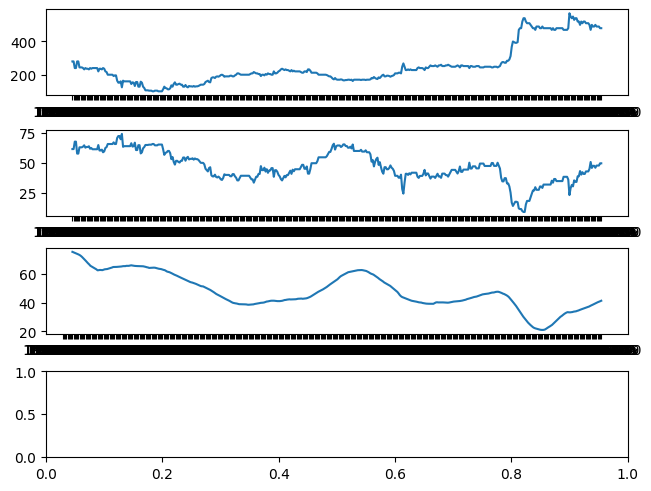

13
1.199999999999997
0.7779300691421972
-51.77583232396461
-37.39677856860959
0.4140243902439024


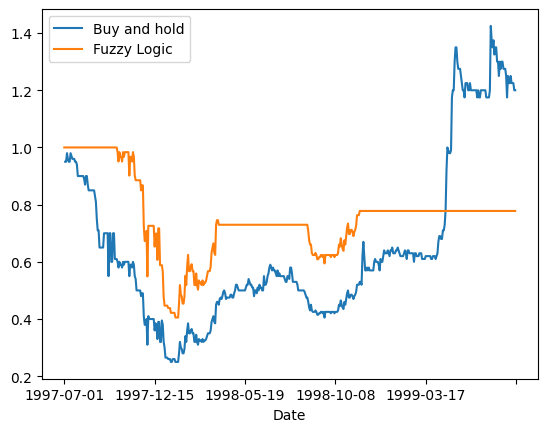

In [21]:
genome1 = Genome(test_gene_list)
# genome1 = Genome(gene_list)
# genome1.initialize_genome()
stock, num_trades, bnh_returns, strat_returns, strat_sharpe_ratio, strat_sortino_ratio, max_drawdown= evaluate_fitness(train_set[2500], genome1)
# print(returns)
print(num_trades)
print(bnh_returns)
print(strat_returns)
print(strat_sharpe_ratio)
print(strat_sortino_ratio)
print(max_drawdown)

In [34]:
# for i in range(len(stock.df)):
#     print(stock.df["RSI30"][i].round(2),'\t',stock.df["change"][i].round(2), '\t', stock.df["z_sum_rolling"][i], '\t', stock.df["regime"][i])

nan 	 nan 	 nan 	 0
nan 	 0.95 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.03 	 nan 	 0
nan 	 0.98 	 nan 	 0
nan 	 0.99 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.03 	 nan 	 0
nan 	 0.99 	 nan 	 0
nan 	 0.99 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 0.99 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 0.99 	 nan 	 0
nan 	 0.96 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 0.99 	 nan 	 0
nan 	 0.98 	 nan 	 0
nan 	 1.03 	 nan 	 0
nan 	 1.0 	 nan 	 0
nan 	 0.97 	 nan 	 0
nan 	 0.98 	 nan 	 0
nan 	 1.0 	 nan 	 0
25.88 	 1.0 	 nan 	 0
25.88 	 1.0 	 nan 	 0
25.88 	 1.0 	 nan 	 0
25.88 	 1.0 	 nan 	 0
25.88 	 1.0 	 nan 	 0
23.15 	 0.98 	 nan 	 0
20.87 	 0.98 	 nan 	 0
15.99 	 0.93 	 nan 	 0
13.77 	 0.95 	 nan 	 0
13.77 	 1.0 	 nan 	 0
11.26 	 0.92 	 nan 	 0
11.26 	 1.0 	 nan 	 0
11.26 	 1.0 	 nan 	 0
11.26 	 1.0 	 nan 	 0
11.26 	 1.0 	 nan 	 0
24.8 	 1.08 	 nan 	 0
24.8 	 1.0 	 nan 	 0
24.8 	 1.0 	 nan 	 0
24.8 	

In [24]:
class Population():
    """
    Some text
    
    """
    population_id = itertools.count()
    
    
    def __init__(self):
        """
        This function initializes a gene object
        
        Arguments:
            self:
                some text
                
        Returns:
            None
        """
        self.population_id = next(Population.population_id)
        self.population = list()
    
    def initialize_population(self, genome:Genome, num_genomes:int = 100):
        """
        This function initializes the first population of the genetic algorithm
        
        Arguments:
            self:
                some text
                
        Returns:
            None
        """
        self.population = list()
        for _ in range(num_genomes):
            self.population.append(copy.deepcopy(genome))
            self.population[_].initialize_genome()
                
        
    def select_genes(self):
        """
        This function is the selection phase of the genetic algorithm
        
        Arguments:
            population: list[gene]
                a list of genes to be evaluated and selected for the next generation
                
        Returns
            selected_population: list[gene]
                a list of genes selected to proceed to the next generation
        """
        pass

    def load_from_checkpoint(self):
        pass
        
        
    

In [25]:
population1 = Population()
population1.initialize_population(num_genomes = 5, genome = genome1)

for genome in population1.population:
    print(genome)
    

Gene name: RSI_window
Value: 256

Gene name: RSI_p1
Value: -0.06833882329752705

Gene name: RSI_p2
Value: -0.4298274703339733

Gene name: RSI_p3
Value: -0.4463544806008011

Gene name: RSI_p4
Value: 0.8999663030905378

Gene name: RSI_low_membership
Value: [89, 98]

Gene name: RSI_middle_membership
Value: [21, 79, 91]

Gene name: RSI_high_membership
Value: [99, 100]

Gene name: entry_condition
Value: [58, 75]

Gene name: stop_loss
Value: 0.6402816079538592

Gene name: z_rolling_window
Value: 163


Gene name: RSI_window
Value: 170

Gene name: RSI_p1
Value: 0.8910094977887186

Gene name: RSI_p2
Value: 0.3889215489325166

Gene name: RSI_p3
Value: 0.13873964939494354

Gene name: RSI_p4
Value: -0.9391350684439239

Gene name: RSI_low_membership
Value: [28, 62]

Gene name: RSI_middle_membership
Value: [11, 17, 29]

Gene name: RSI_high_membership
Value: [93, 99]

Gene name: entry_condition
Value: [64, 84]

Gene name: stop_loss
Value: 0.6892098520330409

Gene name: z_rolling_window
Value: 283


G

In [26]:
def single_point_crossover(genome1, genome2):
    """
    This function performs a crossover between two genes; this function
    returns an offspring.
    
    Arguments:
        genome1: Genome
            a genome object to be crossed over to gene2
        
        genome2: Genome
            a genome object to be cross over to gene 1
            
    Returns:
        offspring: Optional[Genome, None]
            the offspring due to the crossover of gene1 and gene2;
            if the offsprings is not a valid genome, the function
            returns None
    """
    pass

In [27]:
def two_point_crossover():
    """
    Some text
    """
    pass

In [28]:
def linear_crossover():
    """
    Some text
    """
    pass


In [29]:
def polynomial_crossover():
    """
    Some text
    """
    pass
    

In [30]:
def SBX():
    """
    Some text
    """
    pass

In [31]:
def run_evolution(population = None, generations:int = None, checkpoint_interval:int = None) -> None:
    """
    This function simulates evolution through the population
    of genes
    
    Arguments:
        population: population class
            a class of population
        
        generations: int
            the number of generations the evolution should run
            
        checkpoints: int
            the interval for saving a checkpoint in the evolution of the genomes
            
    Returns:
        None
        
    """
    pass


    # TODO: include checkpoints here




In [32]:
def main() -> None:
    """
    This function runs all the other functions as provided in the above
    """
    pass
    # use multiprocessing here